In [211]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [221]:
metadata = pd.read_excel('../../Data/Manuscript_DessislavaVeltcheva_Dataframe.xlsx').set_index('id')
metadata['resistance'] = metadata['IT_to_RS_conversion'] == 'R'

In [222]:
matrix = pd.DataFrame(np.load("../../Data/13672_analysis/Average_matrix.npy"))

In [223]:
with open('../../Data/13672_analysis/tree_label.txt') as fh:
    labels = fh.readline()
    labels = fh.readline()
allLabels = []
for label in labels.split(','):
    x = label.strip('"[] \'\n')
    allLabels.append(int(x))

In [224]:
matrix.columns = allLabels
matrix.index = allLabels

In [227]:
matrix[5858].sort_values()

77729      0.000000
57198      0.000000
70143      0.000000
38978      0.000000
22686      0.000000
            ...    
28291    707.053332
40063    707.053332
41581    707.053332
40440    707.053332
39797    707.053332
Name: 5858, Length: 13672, dtype: float64

In [9]:
matrix = (
    matrix.reset_index().rename({'index': 'ID1'}, axis=1)
    .melt(id_vars='ID1')
    .rename({'variable': 'ID2', 'value': 'branchLength'}, axis=1)
)

In [10]:
matrix = matrix.loc[matrix['ID1'] < matrix['ID2']]

In [11]:
mergeCols = ['resistance', 'clonal_complex..MLST.']

In [12]:
matrix = (
    pd.merge(matrix, metadata[mergeCols],left_on='ID1', right_index=True)
    .rename({'resistance': 'ID1resistance', 'clonal_complex..MLST.': 'ID1cc'}, axis=1)
)

KeyboardInterrupt: 

In [56]:
matrix = (
    pd.merge(matrix, metadata[mergeCols],left_on='ID2', right_index=True)
    .rename({'resistance': 'ID2resistance', 'clonal_complex..MLST.': 'ID2cc'}, axis=1)
)

In [57]:
matrix['sumResistance'] = matrix[['ID1resistance', 'ID2resistance']].sum(axis=1)

In [65]:
matrix['sameCC'] = matrix['ID1cc'] == matrix['ID2cc']

In [76]:
matrix.to_pickle('matrix_res_comparison.pkl')

In [70]:
g = matrix.loc[matrix['sameCC']].groupby(['ID1cc', 'sumResistance'])['branchLength'].mean().reset_index()

In [218]:
matrix = pd.read_pickle('matrix_res_comparison.pkl')

In [214]:
def setLabel(x):
    if x == 2:
        return 'Resistant'
    elif x == 0:
        return 'Susceptible'
    else:
        return 'Susceptible / Resistant'
matrix['status'] = matrix['sumResistance'].apply(setLabel)

matrix = matrix.loc[
    (matrix['status'] != 'Susceptible / Resistant')
]

In [215]:
def resistanceLengths(x):
    """ Get resistance of nearest neighbour """
    l = x.loc[x['targetResistance'], 'branchLength'].sort_values().head(1)
    return l

def notResistanceLength(x):
    """Get resistance of random neighbout """
    l = x.loc[~x['targetResistance'], 'branchLength'].sort_values().head(1)
    return l

In [216]:
allCC = matrix['ID1cc'].unique()
allData = []
for cc in allCC:
    print(f'Processing {cc}', file=sys.stderr)
    # Filter by CC
    cols = ['ID1', 'ID2', 'branchLength', 'ID1resistance', 'ID2resistance']
    sub = matrix.loc[
        (matrix['ID1cc'] == cc) & (matrix['sameCC']), cols
    ]

    id1 = sub[['ID1', 'ID2', 'branchLength', 'ID2resistance', 'ID1resistance']].copy()
    id1.columns = ['ref', 'target', 'branchLength', 'targetResistance', 'refResistance']
    id2 = sub[['ID2', 'ID1', 'branchLength', 'ID1resistance', 'ID2resistance']].copy()
    id2.columns = ['ref', 'target', 'branchLength', 'targetResistance', 'refResistance']
    sub2 = pd.concat([id1, id2])

    # How far to to travel to meet your nearest resistant neighbout
    resistanceLengths = sub2.loc[sub2['refResistance']].groupby('ref').apply(resistanceLengths).reset_index()
    resistanceLengths['type'] = 'Resistant'

    susceptibleLengths = sub2.loc[~sub2['refResistance']].groupby('ref').apply(notResistanceLength).reset_index()
    susceptibleLengths['type'] = 'Susceptible'
    
    merged = pd.concat([resistanceLengths, susceptibleLengths]).reset_index()
    merged['cc'] = cc
    
    allData.append(merged)
allData = pd.concat(allData).reset_index(drop=True)

Processing ST-21 complex
Processing ST-45 complex


TypeError: unhashable type: 'DataFrame'

In [180]:
g = sns.catplot(data=allData, x='type', y='branchLength', kind='box', col='cc', col_wrap=6)

In [217]:
merged

,index,ref,level_1,branchLength,type,cc
0,0,5858,14843880,0.000000e+00,Resistant,ST-21 complex
1,1,5889,121280413,0.000000e+00,Resistant,ST-21 complex
2,2,5932,136374533,3.925231e-17,Resistant,ST-21 complex
3,3,5955,62914988,0.000000e+00,Resistant,ST-21 complex
4,4,5992,155583963,0.000000e+00,Resistant,ST-21 complex
...,...,...,...,...,...,...
2850,1916,78868,185832266,0.000000e+00,Susceptible,ST-21 complex
2851,1917,78869,185848029,4.931011e-17,Susceptible,ST-21 complex
2852,1918,78882,185979620,0.000000e+00,Susceptible,ST-21 complex
2853,1919,78884,186005536,2.729641e-16,Susceptible,ST-21 complex


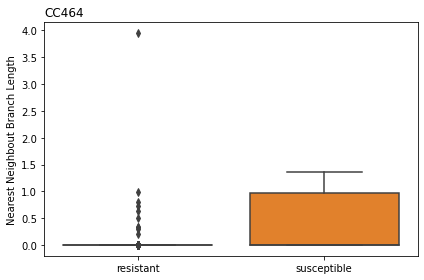

In [206]:
fig, ax = plt.subplots()
sns.boxplot(data=merged, y='branchLength', x='type')
ax.set_title(f'CC{cc}', loc='left')
ax.set_xlabel('')
ax.set_ylabel('Nearest Neighbout Branch Length')
fig.tight_layout()

## Make distribution plots

In [161]:
matrix = matrix.loc[
    (matrix['branchLength'] < 100)
]

In [153]:
pwd

'/Users/user/Library/CloudStorage/OneDrive-Nexus365/PhD/Campy_Analysis_ALL/Code/Non_r'

In [154]:
g = sns.FacetGrid(matrix, hue='status', col='ID1cc', col_wrap=4)
g.map(sns.kdeplot, 'branchLength')
g.add_legend()
g.savefig('../../Figures/Branchlength/branchLengthResSuc.svg')

KeyError: 'status'

In [157]:
matrix.head()

,ID1,ID2,branchLength,ID1resistance,ID1cc,ID2resistance,ID2cc,sumResistance,sameCC
2124,2659,10935,0.645826,True,ST-48 complex,False,NaN,1,False
2125,2663,10935,0.456480,True,ST-353 complex,False,NaN,1,False
2126,2670,10935,0.645826,False,ST-21 complex,False,NaN,0,False
2127,2672,10935,1.487247,True,ST-354 complex,False,NaN,1,False
9760,5858,10935,1.260962,True,ST-21 complex,False,NaN,1,False


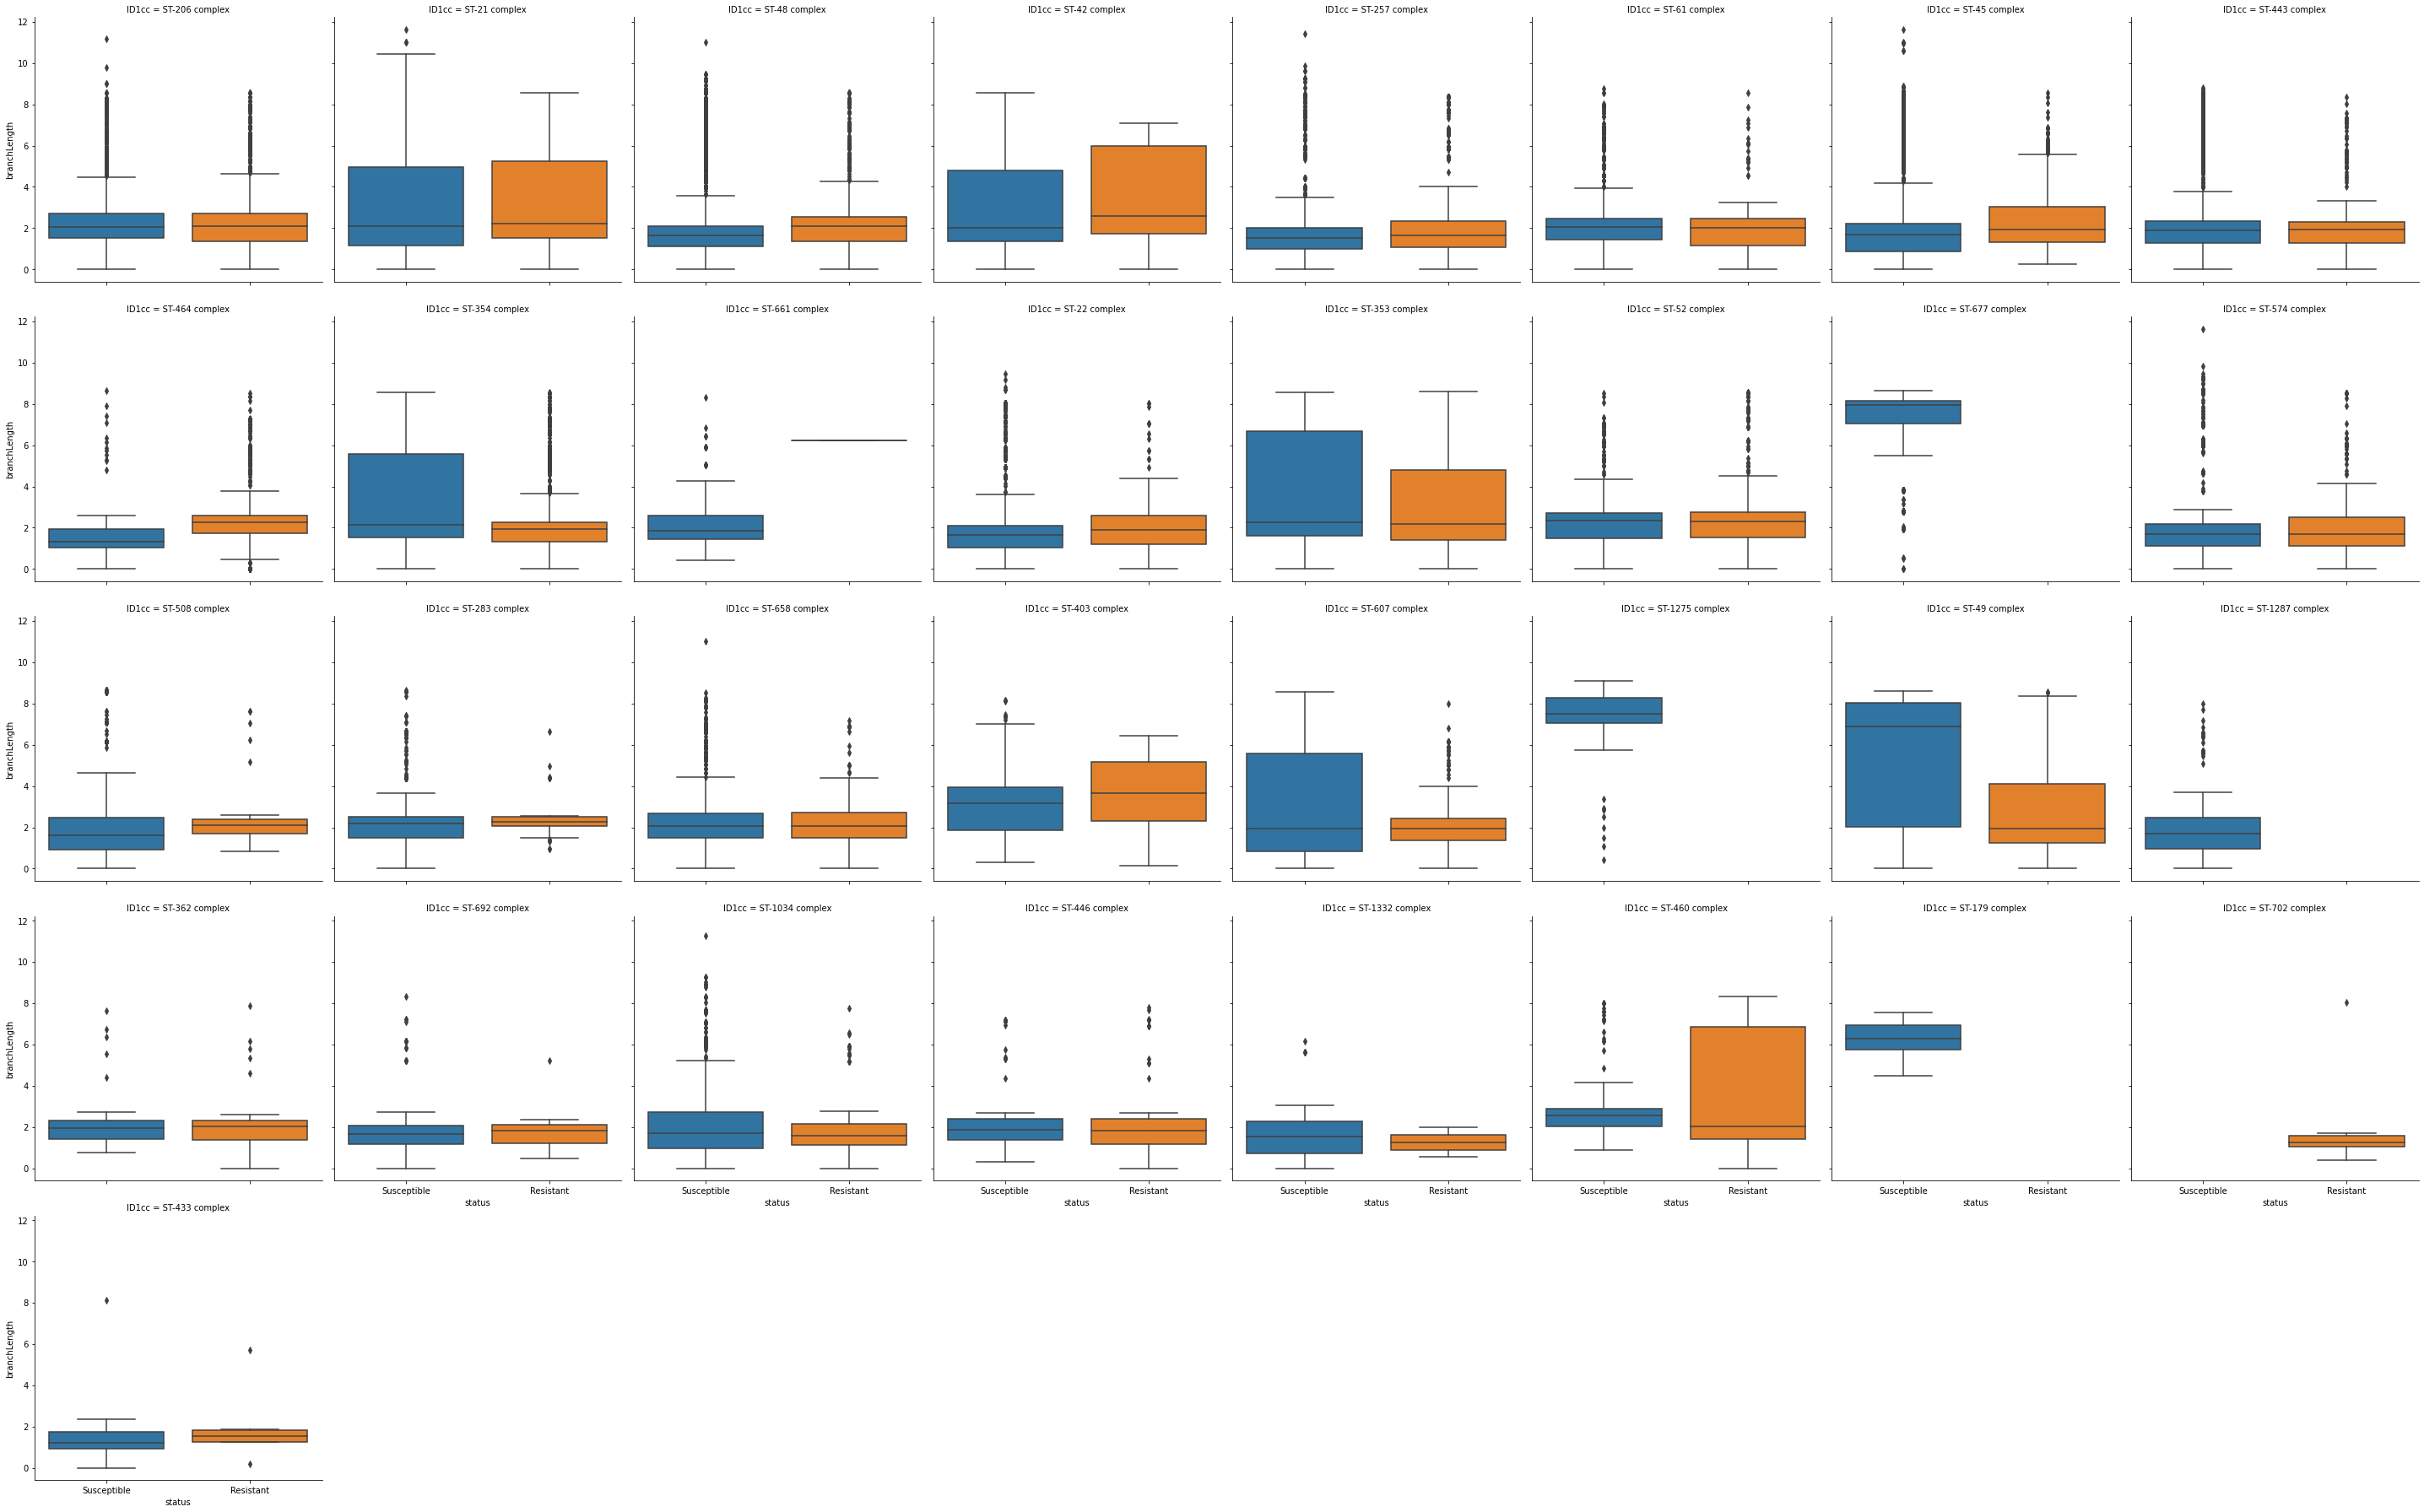

In [170]:
g = sns.catplot(data=matrix.sample(100000), x='status', y='branchLength', kind='box', col='ID1cc', col_wrap=8)
g.savefig('../../Figures/Branchlength/branchLLength-boxplot.svg')

In [16]:
res_sameCC = matrix.query("`sameCC` == True and `sumResistance` == 2")

In [17]:
sus_sameCC = matrix.query("`sameCC` == True and `sumResistance` == 0")

In [18]:
sameCC = matrix.query("`sameCC` == True and `branchLength` < 100")

In [43]:
sameCC_single = sameCC.query("`ID1cc` == 'ST-574 complex'")

In [ ]:
#def my_function():
    #CC_name = sampleCC.query("`ID1cc` == i ")
    #for i in range:
        #fig,ax = plt.subplots()
        #sns.boxplot(data=CC_name, x='status', y='branchLength', ax=ax)
        
        #fig,ax = plt.subplots()
        #sns.kdeplot(data=sameCC_single, x='branchLength', hue='status', common_norm=False, ax=ax)

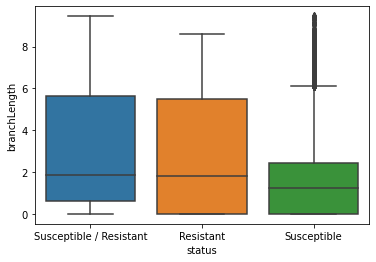

In [133]:
fig,ax = plt.subplots()
sns.boxplot(data=sameCC, x='status', y='branchLength', ax=ax)

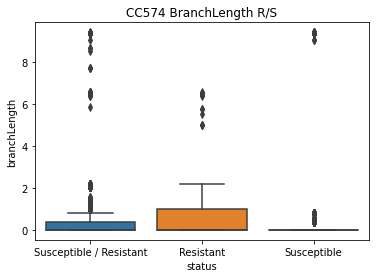

In [44]:
fig,ax = plt.subplots()
sns.boxplot(data=sameCC_single, x='status', y='branchLength', ax=ax)
plt.title('CC574 BranchLength R/S')
plt.savefig('../../Figures/Branchlength/CC574_Boxplot.png')

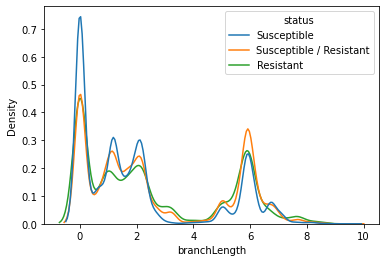

In [157]:
fig,ax = plt.subplots()
sns.kdeplot(data=sameCC.sample(1000000), x='branchLength', hue='status', common_norm=False, ax=ax)

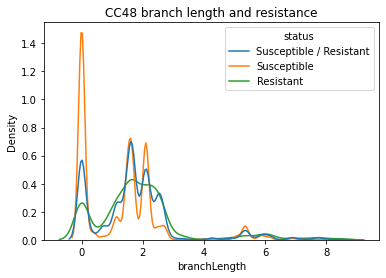

In [201]:
fig,ax = plt.subplots()
a = sns.kdeplot(data=sameCC_single, x='branchLength', hue='status', common_norm=False, 
                ax=ax)

plt.title('CC48 branch length and resistance')
plt.savefig('../../Figures/Branchlength/CC48_BranchLength_RS.png')

In [29]:
res_sameCC.describe()

,ID1,branchLength,sumResistance
count,679349.000000,6.793490e+05,679349.0
mean,33905.726796,2.886814e+00,2.0
std,14632.663771,1.533122e+01,0.0
min,2659.000000,0.000000e+00,2.0
25%,23573.000000,2.011083e-16,2.0
50%,32843.000000,1.825675e+00,2.0
75%,41486.000000,5.504560e+00,2.0
max,78452.000000,7.079876e+02,2.0


In [31]:
sus_sameCC.describe()

,ID1,branchLength,sumResistance
count,3.135086e+06,3.135086e+06,3135086.0
mean,3.350131e+04,3.020398e+00,0.0
std,1.561607e+04,2.585252e+01,0.0
min,2.670000e+03,0.000000e+00,0.0
25%,2.235000e+04,1.019805e-16,0.0
50%,3.132600e+04,1.243835e+00,0.0
75%,4.199100e+04,2.468991e+00,0.0
max,7.888400e+04,7.079641e+02,0.0


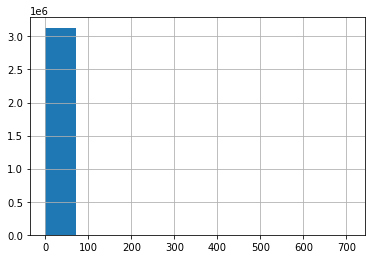

In [34]:
sus_sameCC['branchLength'].hist()

In [37]:
sus_sameCC.plot.scatter

<bound method PlotAccessor.scatter of <pandas.plotting._core.PlotAccessor object at 0x7fd4788d9e80>>

(-1.0, 12.0)

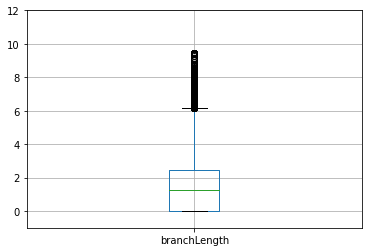

In [92]:
a = sus_sameCC.boxplot(column=['branchLength'])
plt.ylim(-1,12)

(-1.0, 12.0)

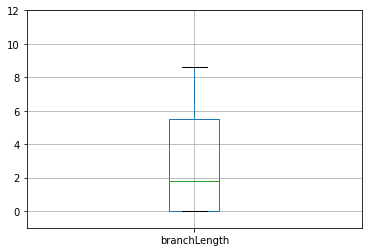

In [96]:
b = res_sameCC.boxplot(column=['branchLength'])
plt.ylim(-1,12)

In [90]:
ax = data[['a', 'b']].plot(kind='box', title='boxplot')

NameError: name 'data' is not defined

In [42]:
type(sus_sameCC)

pandas.core.frame.DataFrame

In [41]:
sus_sameCC.head()

,ID1,ID2,branchLength,ID1resistance,ID1cc,ID2resistance,ID2cc,sumResistance,sameCC
78135,5891,12882,2.096334,False,ST-48 complex,False,ST-48 complex,0,True
78482,5956,12882,2.096334,False,ST-48 complex,False,ST-48 complex,0,True
78607,5979,12882,2.096334,False,ST-48 complex,False,ST-48 complex,0,True
78687,6082,12882,1.633440,False,ST-48 complex,False,ST-48 complex,0,True
78701,6109,12882,2.096334,False,ST-48 complex,False,ST-48 complex,0,True


In [43]:
sus_sameCC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3135086 entries, 78135 to 160452649
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID1            int64  
 1   ID2            object 
 2   branchLength   float64
 3   ID1resistance  bool   
 4   ID1cc          object 
 5   ID2resistance  bool   
 6   ID2cc          object 
 7   sumResistance  int64  
 8   sameCC         bool   
dtypes: bool(3), float64(1), int64(2), object(3)
memory usage: 176.4+ MB


(0.0, 4.0)

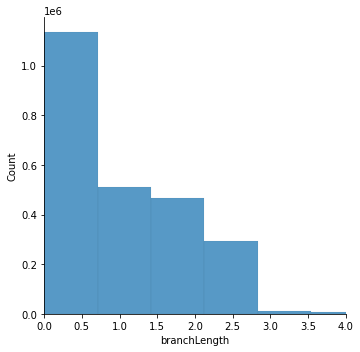

In [77]:
sns.displot(data=sus_sameCC, x="branchLength",bins = 1000)
plt.xlim(0,4)

(0.0, 4.0)

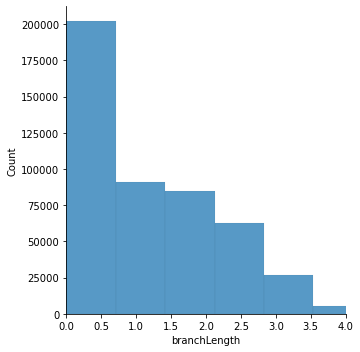

In [76]:
sns.displot(data=res_sameCC, x="branchLength",bins = 1000)
plt.xlim(0,4)